In [3]:
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk import accuracy
from numpy.ma.core import argmax
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch import dtype
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from BayesianLLNN import BayesianLastLayer,PredLastLayer,TrainLastLayer,BaseNetwork,TrainLastLayerCL, PredLastLayerCl, BaseNetworkCL
from baseNN import GetNeuralNetwork, PredNormal, TrainNN, GetNeuralNetworkClassification, TrainNNClass, PredictClass

Loading Dataset

In [4]:
np.random.seed(123)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [5]:
# load dataset, medical, diabetes, relevant. Diagnosis
df = pd.read_csv("/Users/kingmopser/PycharmProjects/ProbabilisticML/Dataset of Diabetes .csv")
df.drop(columns=["ID","No_Pation"], inplace=True)

Pre-Processing for Input Data

In [6]:
scaler = StandardScaler()
encoder =LabelEncoder()
df["Gender"] = df["Gender"].apply(lambda x: 1 if x=="M" else 0)
c = df.columns[1:len(df.columns)-1]
df[c] =scaler.fit_transform(df[c])
df["CLASS"] = df["CLASS"].apply(lambda x: "N" if re.match(r"N",x) else "P" if x=="P" else "Y" if re.match(r"Y",x) else 0)
df["CLASS"]= pd.Categorical(df["CLASS"], categories=["N","P","Y"], ordered=True)
df["CLASS"] = encoder.fit_transform(df["CLASS"])

In [7]:
X = df.iloc[:,:-1].to_numpy(dtype=np.float32)
y= df['CLASS'].to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8)
tenX = torch.tensor(X_train).to(device)
tenY = torch.tensor(y_train).to(device)
tenXTest = torch.tensor(X_test).to(device)
tenYTest = torch.tensor(y_test).to(device)
tenDF = TensorDataset(tenX,tenY)
trainLoader = DataLoader(tenDF,batch_size=32,shuffle=True)

Creating OOD samples


In [6]:
# Feature-Namen ohne Gender
#feature_names = df.columns[1:len(df.columns)-1]
# Wähle beliebige Werte außerhalb des Trainingsbereichs, z. B. +5 und -5 Standardabweichungen
#n_ood = 50  # wie viele OOD-Beispiele pro Feature

#ood_samples = []
#for i, feature in enumerate(feature_names):
    # Template: Mittelwert aller Features (z. B. aus X_train)
#    base = np.mean(X_train, axis=0)
    # Für dieses Feature Wert weit außerhalb setzen (+5)
#    ood_high = base.copy()
#    ood_high[i] = 8  # oder beliebig >3

#    ood_low = base.copy()
 #   ood_low[i] = -8  # oder beliebig <-3

  #  ood_samples.append(ood_high)
   # ood_samples.append(ood_low)

# Zu Array zusammenfügen
#X_ood = np.stack(ood_samples)
#X_ood = np.column_stack((np.zeros(len(X_ood)),X_ood[:,:-1]))
#y_ood = np.zeros(len(X_ood))
# Dummy, wenn Label nötig, ansonsten ignorieren
#X_test_ODD= np.vstack([X_test,X_ood])
#y_test_OOD=np.concatenate([y_test, y_ood])
# Zu Tensor (optional)
#tenX_OOD = torch.tensor(X_test_ODD, dtype=torch.float32).to(device)
#tenY_OOD = torch.tensor(y_test_OOD, dtype=torch.float32).to(device)
#MASK
#is_ood = np.array([False]*len(X_test) + [True]*len(X_ood))

In [8]:
base = np.mean(X_train, axis=0)  # shape: (n_feats+1,), falls die erste Spalte evtl. Label/Index war
n_ood = 100
ood_samples = []
for _ in range(n_ood):
    # Erzeuge Vektor, bei dem alle Features +4 bekommen
    ood_high_all = base.copy()
    # Index 0 überspringen wir später ohnehin (ist evtl. das Label oder konstante Spalte)
    ood_high_all[:] = np.random.choice([np.random.uniform(5,9),np.random.uniform(-4,-8) ], size=len(ood_high_all))  # alle Feature-Spalten auf +4 setzen

    ood_samples.append(ood_high_all)
#    ood_samples.append(ood_low_all)

# Aus Liste ein Array machen
X_ood = np.stack(ood_samples)  # shape: (2*n_ood, n_feats+1)

# Wenn du in deinem Setting die erste Spalte hart auf 0 setzen willst
# (wie in deinem Original: np.zeros + Spalten verschieben), dann:
X_ood = np.column_stack((np.random.choice([0,1],size=len(X_ood)), X_ood[:, 1:]))  # erste Spalte 0, Rest Features

# Dummy-Labels (falls nötig)
y_ood = np.zeros(len(X_ood))

# Zusammensetzen mit echtem Test-Set
X_test_OOD = np.vstack([X_test, X_ood])
y_test_OOD = np.concatenate([y_test, y_ood])

tenX_OOD = torch.tensor(X_test_OOD, dtype=torch.float32).to(device)
tenY_OOD = torch.tensor(y_test_OOD, dtype=torch.float32).to(device)


is_ood = np.array([False] * len(X_test) + [True] * len(X_ood))


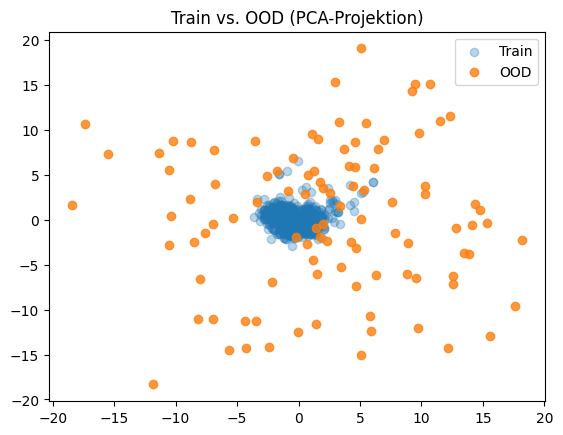

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Z = pca.fit_transform(np.vstack([X_train, X_ood]))
plt.scatter(Z[:len(X_train), 0], Z[:len(X_train), 1], label='Train', alpha=0.3)
plt.scatter(Z[len(X_train):, 0], Z[len(X_train):, 1], label='OOD', alpha=0.8)
plt.legend(); plt.title("Train vs. OOD (PCA-Projektion)")
plt.show()


MAP Model fitting

In [10]:
# BASE NN CLASSIFIER
nn = GetNeuralNetworkClassification(len(df.columns[:-1]),len(np.unique(y)))
TrainNNClass(nn,trainLoader,epochs=100)
prob,mapentr = PredictClass(nn,tenX_OOD)

Epoch: 0 | Loss: 1.08368
Epoch: 10 | Loss: 0.45276
Epoch: 20 | Loss: 0.17523
Epoch: 30 | Loss: 0.25301
Epoch: 40 | Loss: 0.20483
Epoch: 50 | Loss: 0.09060
Epoch: 60 | Loss: 0.09454
Epoch: 70 | Loss: 0.01172
Epoch: 80 | Loss: 0.18772
Epoch: 90 | Loss: 0.30715


Bayesian LL Classifier fitting


In [11]:
# bayesian
base = BaseNetworkCL(len(df.columns[:-1])).to(device)
head = torch.nn.Linear(in_features=4,out_features=len(df["CLASS"].unique())).to(device)
baseMod = torch.nn.Sequential(base,head)
TrainNNClass(baseMod,trainLoader,150)
# freezing base weights
for p in baseMod.parameters():
    p.requires_grad = False
lastLayer = BayesianLastLayer(in_features=4,out_features=len(df["CLASS"].unique()),logvals=-3.0,prior_sigma=2).to(device)
TrainLastLayerCL(base,lastLayer,trainLoader,epochs=150)
mean_prob, entropy,exp_entr ,mi = PredLastLayerCl(base,lastLayer,tenX_OOD)

Epoch: 0 | Loss: 0.98485
Epoch: 10 | Loss: 0.18795
Epoch: 20 | Loss: 0.32376
Epoch: 30 | Loss: 0.16204
Epoch: 40 | Loss: 0.14286
Epoch: 50 | Loss: 0.10261
Epoch: 60 | Loss: 0.21671
Epoch: 70 | Loss: 0.14608
Epoch: 80 | Loss: 0.06314
Epoch: 90 | Loss: 0.10689
Epoch: 100 | Loss: 0.09040
Epoch: 110 | Loss: 0.17029
Epoch: 120 | Loss: 0.05572
Epoch: 130 | Loss: 0.01538
Epoch: 140 | Loss: 0.10393


In [12]:
#MAP
#ID
prob_ID = prob[~is_ood]
mapentr_ID = mapentr[~is_ood]
#OOD
prob_OOD =prob[is_ood]
mapentr_OOD = mapentr[is_ood]



#BAYES
#ID
mean_prob_ID= mean_prob[~is_ood]
pred_ent_ID = entropy[~is_ood]
aleatoric_ID = exp_entr[~is_ood]
epistemic_ID = mi[~is_ood]
#OOD
mean_prob_OOD= mean_prob[is_ood]
pred_ent_OOD = entropy[is_ood]
aleatoric_OOD = exp_entr[is_ood]
epistemic_OOD = mi[is_ood]
print(f"ID: entropy MAP: {mapentr_ID.mean()}, BLL{pred_ent_ID.mean()}, OOD: entropy MAP: {mapentr_OOD.mean()}, BLL { pred_ent_OOD.mean()}")

ID: entropy MAP: 0.1383015662431717, BLL0.17342253029346466, OOD: entropy MAP: 0.06288991868495941, BLL 0.04767002537846565


PLOTS

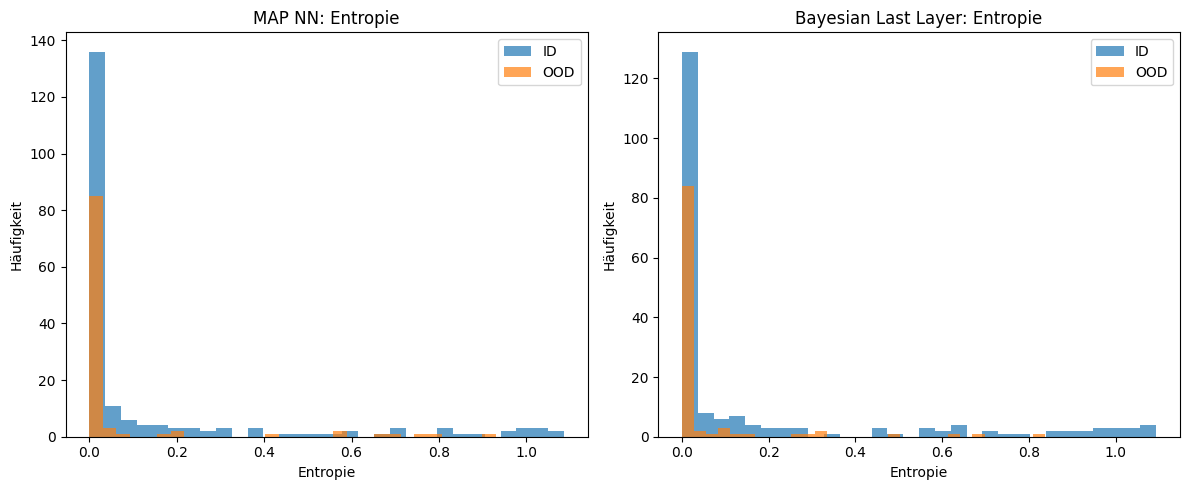

In [13]:
plt.figure(figsize=(12,5))
#MAP ENTROPY
plt.subplot(1,2,1)
plt.hist(mapentr_ID, bins=30, alpha=0.7, label='ID')
plt.hist(mapentr_OOD, bins=30, alpha=0.7, label='OOD')
plt.title('MAP NN: Entropie')
plt.xlabel('Entropie')
plt.ylabel('Häufigkeit')
plt.legend()
 #BLL ENTROPY
plt.subplot(1,2,2)
plt.hist(pred_ent_ID, bins=30, alpha=0.7, label='ID')
plt.hist(pred_ent_OOD, bins=30, alpha=0.7, label='OOD')
plt.title('Bayesian Last Layer: Entropie')
plt.xlabel('Entropie')
plt.ylabel('Häufigkeit')
plt.legend()

plt.tight_layout()
plt.show()

/var/folders/z8/f4xxfstn37ndb5_8bsvv2v2w0000gn/T/ipykernel_8191/3639989144.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


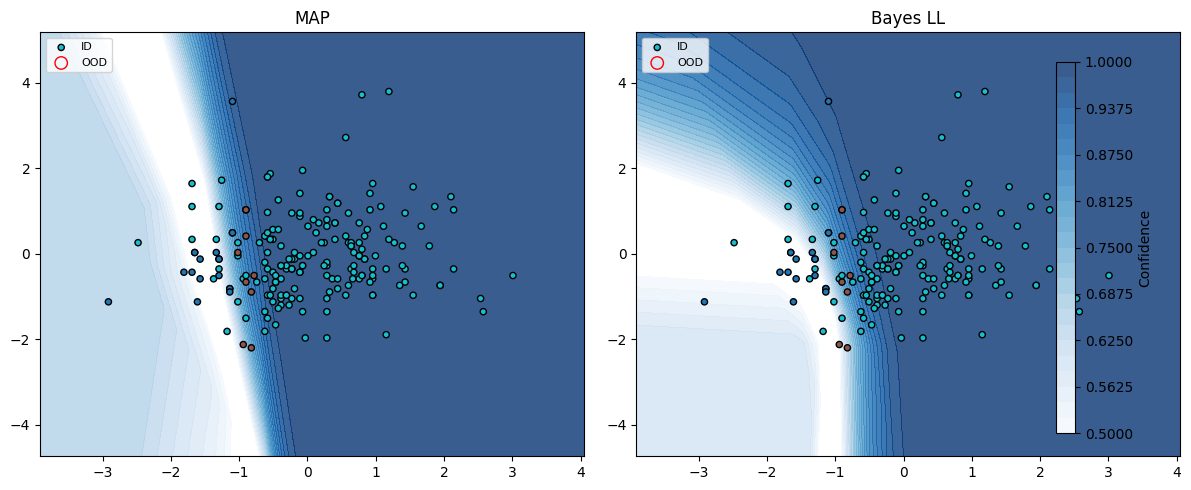

In [99]:
# --- 1) Gitter über zwei Features aufspannen ---
f1, f2 = 4, 5  # z.B. die beiden Top-Features
x1_min, x1_max = X_train[:,f1].min()-1, X_train[:,f1].max()+1
x2_min, x2_max = X_train[:,f2].min()-1, X_train[:,f2].max()+1

xx, yy = np.meshgrid(
    np.linspace(x1_min, x1_max, 300),
    np.linspace(x2_min, x2_max, 300)
)
mean_vec = X_train.mean(axis=0)
grid = np.tile(mean_vec, (xx.size, 1))
grid[:, f1] = xx.ravel()
grid[:, f2] = yy.ravel()
grid_tensor = torch.tensor(grid, dtype=torch.float32).to(device)

# --- 2) MAP- und BLL-Confidence berechnen ---
# MAP
probs_map_all,_ = PredictClass(nn,grid_tensor)
probs_map = probs_map_all.max(axis=1)
probs_class_map = probs_map_all.argmax(axis=1)

# Bayesian Last-Layer
mean_prob_bll, _, _, _ = PredLastLayerCl(base, lastLayer, grid_tensor)
probs_bll = mean_prob_bll.max(axis=1)
prob_class_bll = mean_prob_bll.argmax(axis=1)[0]


# --- 3) Plot für ID vs. OOD ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (title, conf) in zip(axes, [("MAP", probs_map), ("Bayes LL", probs_bll)]):
    cf = ax.contourf(
        xx, yy, conf.reshape(xx.shape),
        levels=np.linspace(0.5, 1.0, 25),
        cmap="Blues", alpha=0.8
    )
    # In-Distribution
    ax.scatter(
        X_test_OOD[~is_ood, f1],
        X_test_OOD[~is_ood, f2],
        c=y_test_OOD[~is_ood],
        cmap="tab10",
        s=20, edgecolor="k",
        label="ID"
    )
    # Out-of-Distribution
    ax.scatter(
        X_test_OOD[is_ood, f1],
        X_test_OOD[is_ood, f2],
        facecolors="none", edgecolors="r",
        s=80, label="OOD"
    )
    ax.set_title(title)
    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    ax.legend(loc="upper left", fontsize=8)

# gemeinsame Farbskala
fig.colorbar(
    cf, ax=axes, orientation="vertical",
    fraction=0.02, pad=0.04,
    label="Confidence"
)
plt.tight_layout()
plt.show()


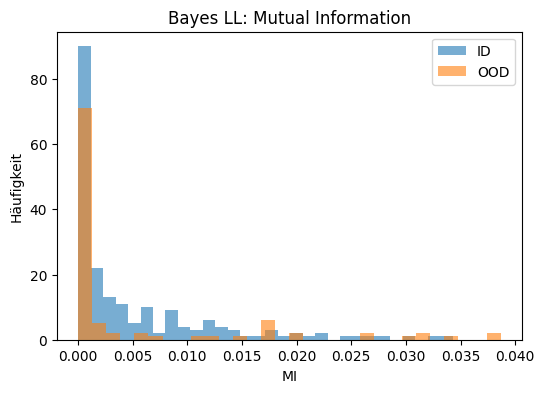

In [100]:
# Nach PredLastLayerCl:
# Plot MI statt Entropie
plt.figure(figsize=(6,4))
plt.hist(mi[~is_ood], bins=30, alpha=0.6, label="ID")
plt.hist(mi[is_ood],  bins=30, alpha=0.6, label="OOD")
plt.title("Bayes LL: Mutual Information")
plt.xlabel("MI")
plt.ylabel("Häufigkeit")
plt.legend()
plt.show()
